In [29]:
%load_ext autoreload
%autoreload 2
import logging
logging.basicConfig(level=logging.INFO)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from luxai_s2.env import LuxAI_S2
import matplotlib.pyplot as plt
import numpy as np
from adl.debugger import Debugger
from agent import Agent
from lux.kit import obs_to_game_state, GameState, EnvConfig
from luxai_s2.utils import animate
from lux.utils import direction_to, my_turn_to_place_factory
from adl.kit import animate, interact

In [3]:
env = LuxAI_S2() # create the environment object
obs = env.reset(seed=41) # resets an environment with a seed

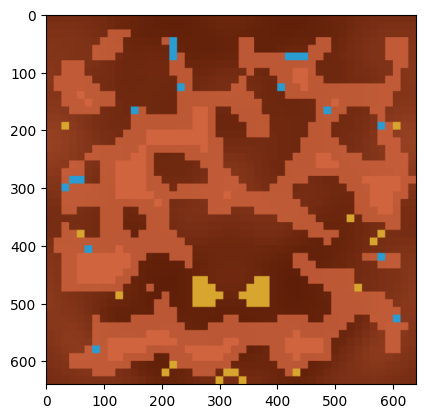

In [4]:
# visualize the environment so far with rgb_array to get a quick look at the map
# dark orange - high rubble, light orange - low rubble
# blue = ice, yellow = ore
img = env.render("rgb_array", width=640, height=640)
plt.imshow(img)

In [5]:
# for seed in range(41, 45):
#     obs = env.reset(seed=seed) # resets an environment with a seed
#     img = env.render("rgb_array", width=640, height=640)
#     plt.figure()
#     plt.imshow(img)

In [6]:
game_state = obs_to_game_state(0, env.state.env_cfg, obs["player_0"])

In [7]:

from sklearn import metrics
from scipy.spatial.distance import cdist

In [8]:
import os
os.environ["OMP_NUM_THREADS"] = '1'
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans

In [9]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}

X = np.argwhere(game_state.board.ice == 1)

maxFactories = 8
maxK = min(int(np.sum(game_state.board.ice)), maxFactories)
K = range(1, maxK+1)

for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k, n_init="auto").fit(X)
    kmeanModel.fit(X)
  
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_



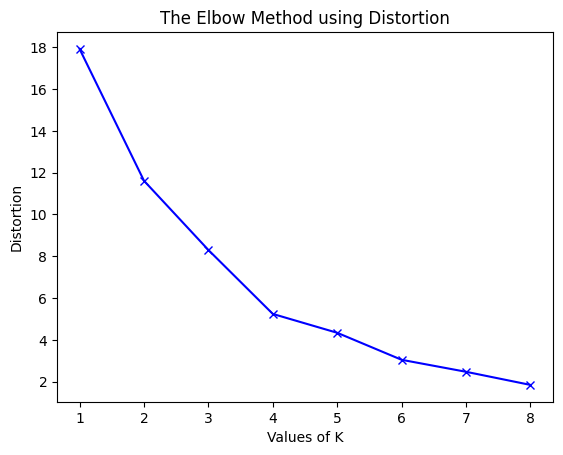

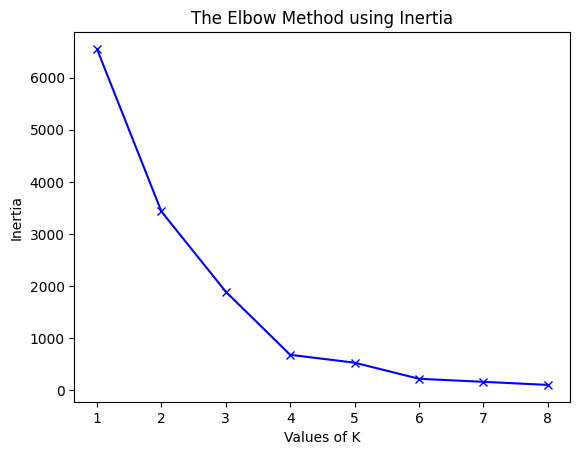

In [10]:
# for key, val in mapping1.items():
#     print(f'{key} : {val}')
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

# for key, val in mapping2.items():
#     print(f'{key} : {val}')
    
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [48]:
from adl.stats import MapStatsManager
mapStatsManager = MapStatsManager()

In [51]:
clusters = mapStatsManager.getResourceCluster(game_state)
clusters

INFO:MapStatsManager:1 : 15.308815530357684
INFO:MapStatsManager:2 : 10.296746020409879
INFO:MapStatsManager:3 : 8.160895821239514
INFO:MapStatsManager:4 : 6.570217275129128
INFO:MapStatsManager:best K : 4


defaultdict(<function adl.stats.map_stats.MapStatsManager.getResourceCluster.<locals>.<lambda>()>,
            {(4, 21): {'ice': 5, 'ore': 2},
             (22, 38): {'ice': 1, 'ore': 32},
             (28, 7): {'ice': 10, 'ore': 1},
             (42, 31): {'ice': 2, 'ore': 4}})

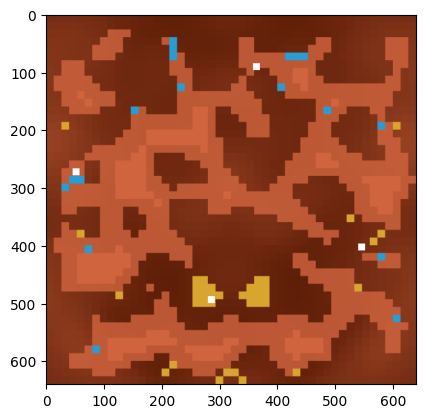

In [52]:
from adl.utils import Utils
img = env.render("rgb_array", width=640, height=640)
Utils.addClustersToImg(img, clusters)
plt.imshow(img)

INFO:MapStatsManager:1 : 17.920117300308547
INFO:MapStatsManager:2 : 11.613397912127963
INFO:MapStatsManager:3 : 8.35686331743564
INFO:MapStatsManager:4 : 5.2418040592409785
INFO:MapStatsManager:best K : 4
INFO:MapStatsManager:1 : 8.70076589734197
INFO:MapStatsManager:2 : 6.638706639857001
INFO:MapStatsManager:best K : 2
INFO:MapStatsManager:1 : 15.308815530357684
INFO:MapStatsManager:2 : 10.296746020409879
INFO:MapStatsManager:3 : 8.160895821239514
INFO:MapStatsManager:4 : 6.570217275129128
INFO:MapStatsManager:best K : 4


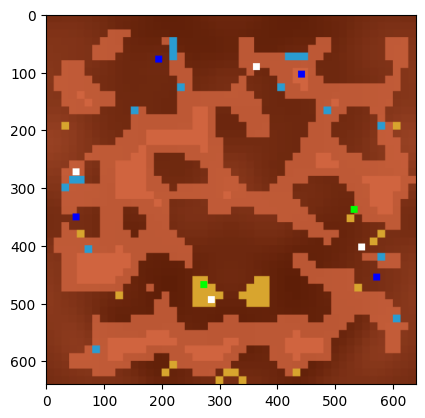

In [53]:
mapStats = mapStatsManager.collectMapStats(game_state)
img = env.render("rgb_array", width=640, height=640)
Utils.addClustersToImg(img, mapStats.iceClusters, np.array([0, 0, 255]))
Utils.addClustersToImg(img, mapStats.oreClusters, np.array([0, 255, 0]))
Utils.addClustersToImg(img, mapStats.resourceClusters, 255)
plt.imshow(img)

In [ ]:
img.shape

In [ ]:

from lux.kit import GameState, obs_to_game_state, Board
def clusterQuality(clusters:Dict[np.ndarray, int], board: Board, interCluserDistance: int):
    # quality is a relative one
    totalRubbleInside = 0
    totalRubbleOutside = 0
    
    